# Predicting Forest Fires Area in Portugual

<br>

In this project we aim to create models that can predict the area(in ha) burned in fires. We will be working with data from the UCI machine learning [repository](http://archive.ics.uci.edu/ml/datasets/Forest+Fires) and is a collection curated by scientists Paulo Cortez and Anibal Morais from the Unviersity of Minho, Portugal. 

The data includes meteorological measurements taken at the time the fire was reported, `spatial/temporal measurements, and index metrics` that take into a account weather data in the recent past. The index metrics are a part of the **Canadian Fire Weather Index System (FWI)**. The data was collected from January 2000 to December 2003 from the northeast region of Portugal. Data was collected from a total of 517 fires.

Many different ML models can be applied - in the basis [paper](http://archive.ics.uci.edu/ml/datasets/Forest+Fires) the one who achieved the best performance was Support Vector Machines (SVM) although Random Forest also achieved a good performance. We will compare our findings in the end with the ones achieved from Paulo Cortez and Anibal Morais.<br>


## Data Exploration
<br>

Our first step will be to explore the variables and perform data manipulation techniques, if necessary, in order to prepare the dataset for secondary steps such as applying Machine Learning methods. We will check aspects such as the statistical distribution of the variables and how are they correlated to each other (if they are). 

Firstly, lets import the librarys used in this project and load the dataset. 
In sequence the features will be described with details that were provided by the source of the dataset.

<br>

#### Import libraries

In [48]:
library(ggplot2)
library(GGally)
library(MASS)
library(data.table)
library(grid)
library(gridExtra)
library(lattice)
library(dplyr)
library(PerformanceAnalytics)

#### Load the Data 

In [49]:
df_fires <- read.csv(file="forestfires.csv", header=TRUE, sep=",")

In [50]:
head(df_fires) # Dysplay first six rows of the table 

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
,<int>,<int>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0
2,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0
3,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0
4,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0
5,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0
6,8,6,aug,sun,92.3,85.3,488.0,14.7,22.2,29,5.4,0.0,0


### Attribute information:


**1. Spatial information**
   - `X`:      x-axis spatial coordinate within the Montesinho park map: 1 to 9
   -  `Y`:     y-axis spatial coordinate within the Montesinho park map: 2 to 9
   
**2. Temporal information**
   - `month`:  month of the year: "jan" to "dec" 
   - `day`:    day of the week: "mon" to "sun"
   
**3. FWI: The forest Fire Weather Index (FWI). Which is the Canadian system for rating fire danger.**
   - `FFMC`:   FFMC index from the FWI system: 18.7 to 96.20
   - `DMC`:    DMC index from the FWI system: 1.1 to 291.3 
   - `DC`:     DC index from the FWI system: 7.9 to 860.6 
   - `ISI`:    ISI index from the FWI system: 0.0 to 56.10
   - `temp`:   temperature in Celsius degrees: 2.2 to 33.30
   
**4. Methorological information**
   - `RH`:     relative humidity in %: 15.0 to 100
   - `wind`:   wind speed in km/h: 0.40 to 9.40 
   - `rain`:   outside rain in mm/m2 : 0.0 to 6.4 
   
**5. area**:   the burned area of the forest (in ha): 0.00 to 1090.84 


------------------------------------------------------------------------------------------------------------------------

###  Understanding the burned area distribution 
As previously stated we aim to predict the area of the fire according to the other variables. it is logical that we start our data exploration from the area. A first look at the table above show that the area is 0 in all of the first rows which is a concern. The authors in their *paper* have explained that an area smaller than $100m^2$ is replaced by 0. Lets check the distribution using an histogram.

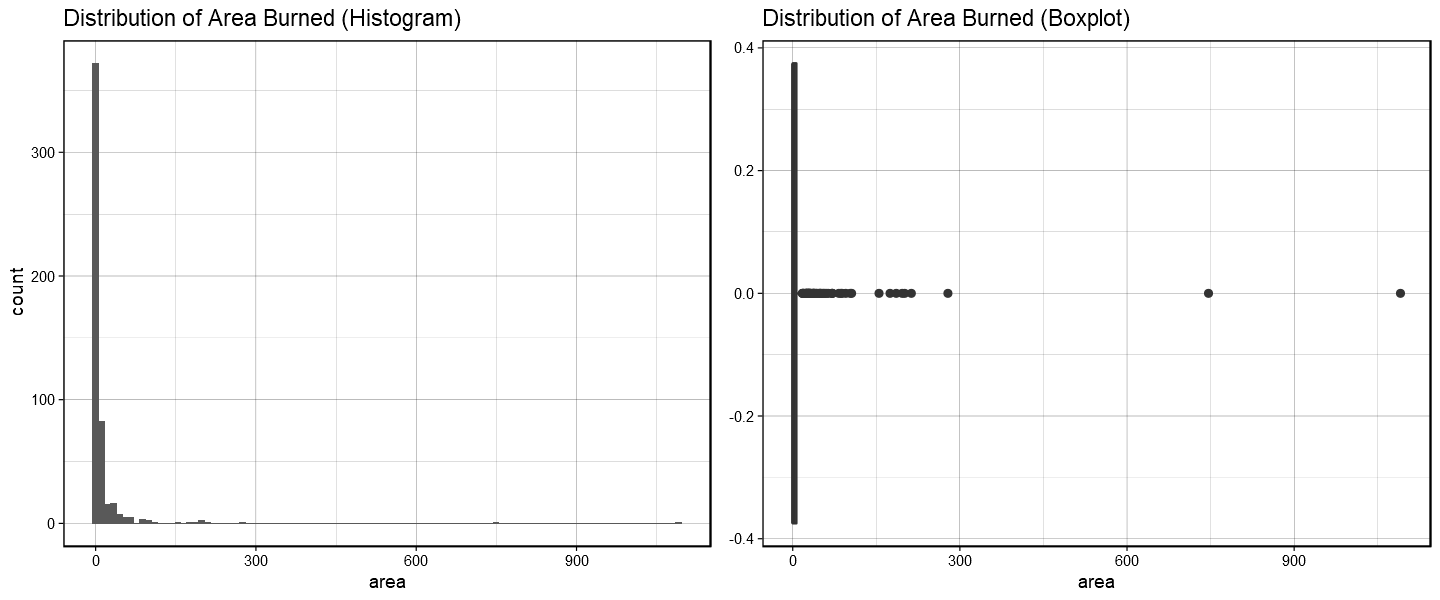

In [56]:
options(repr.plot.width=12, repr.plot.height=5) # area of display

plot1 <- ggplot(df_fires, aes(area)) + geom_histogram(bins = 100) + 
theme_linedraw() + 
ggtitle("Distribution of Area Burned (Histogram)")

plot2 <- ggplot(df_fires, aes(area)) + geom_boxplot() + 
theme_linedraw()+ 
ggtitle("Distribution of Area Burned (Boxplot)")


grid.arrange(plot1, plot2, nrow = 1) # display of first plot

This is an extremely skewed variable and most likely to make a prediction we will have to handle it accordingly. We plan to do a regression in the future and this might be a problem, because for the residuals to be normal the dependent variable cannot have a extremely skewed distribution (as this one). A possible first strategy is to apply the `logarithm` and see how the data will reshape. Important: As we saw many of the data points of area are equal to 0 - so we cannot pass the pure log, but instead we will apply the formula $y = (log_{10}x+1)$

#### Log transformation on the area

In [57]:
df_fires$logarea <- log(df_fires$area+1)

Lets check the effect on the distribution of the area.

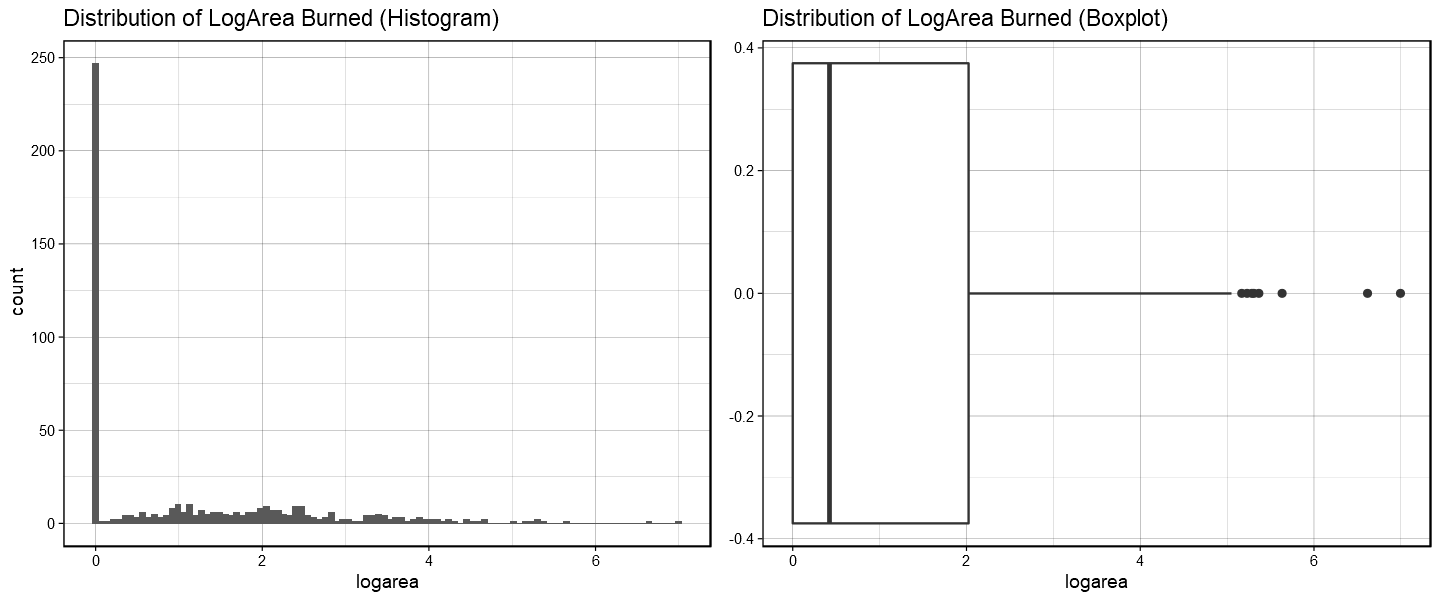

In [60]:
plot3 <- ggplot(df_fires, aes(logarea)) + geom_histogram(bins = 100) + 
theme_linedraw() + 
ggtitle("Distribution of LogArea Burned (Histogram)")

plot4 <- ggplot(df_fires, aes(logarea)) + geom_boxplot() + 
theme_linedraw()+ 
ggtitle("Distribution of LogArea Burned (Boxplot)")

grid.arrange(plot3, plot4, nrow = 1) # display of first plot

Our data remains skilled, however, can see improve in the distribution of the data. We will make a final analysis, by checking what happens if we do not consider the very small fires (size 0). 

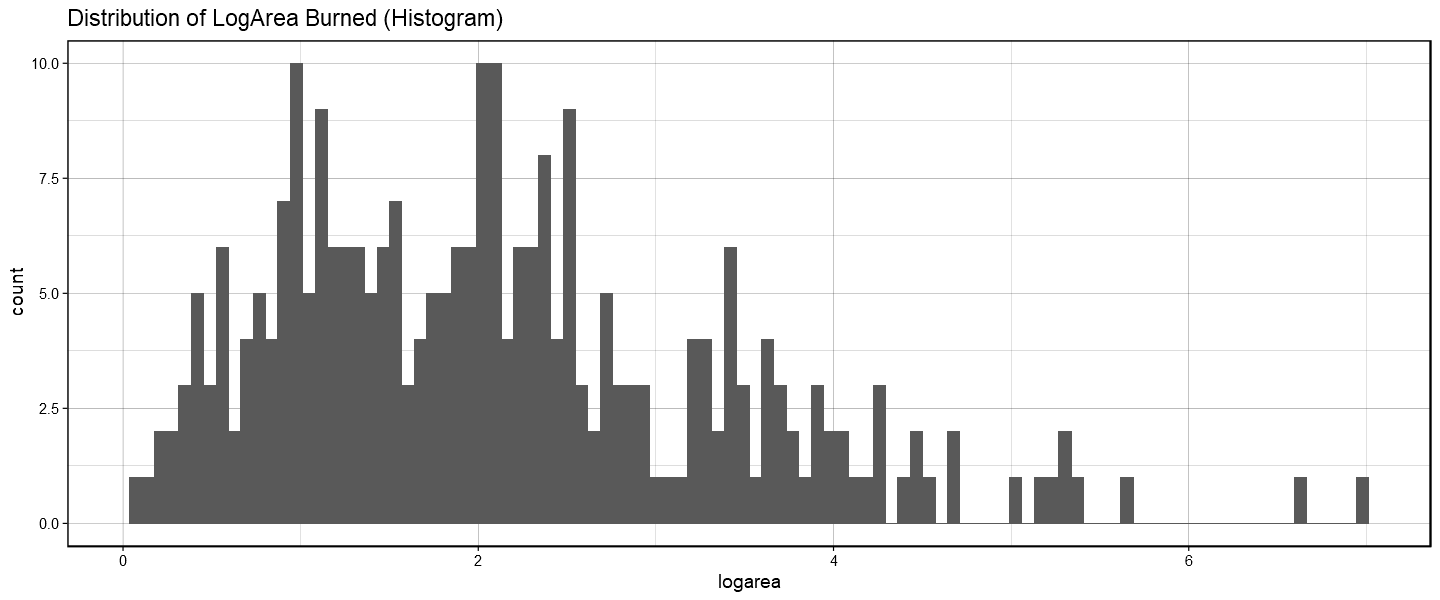

In [71]:
ggplot(df_fires[df_fires$logarea!= 0,], aes(logarea)) + geom_histogram(bins = 100) + 
theme_linedraw() + ggtitle("Distribution of LogArea Burned (Histogram)")

We have found a good distribution to work with, however, we still have to consider the small fires in our analysis. 

### Spatial Analysis
The dataset contains spatial information representing the fires location. The X and Y variables represent the geographical locations in a map and can only be analysed together to make sense. The X axis ranges from 1 to 9 (integers) while the y axis from 2 to 9. Together, they form an area of 72 spaces. We will develop heatmaps in the folowing to identify areas that have been particular areas of focus of fires with respect to:
- The area affected.
- The number of fires.
- Other variables that we might want to compare

In [12]:
# create a table 
df_spatial <- df_fires %>%
  group_by(X,Y) %>%
  summarize(Total_Area = sum(area, na.rm = TRUE),
            Count_Fires  = n(), 
            temp = median(temp, na.rm = TRUE),
            RH = median(RH, na.rm = TRUE),
            wind = median(wind, na.rm = TRUE),
            rain = median(rain, na.rm = TRUE))

We want to develop a very specific heatmap, with many different features. To simplify the process of plotting we will create a function that will be used to make applied to make different plots.

In [13]:
areaheatplot <- function(scale, tittle) 

{
    Total.heatmap <- ggplot(data = df_spatial, mapping = aes(x = X, y = Y, fill = scale)) + 
    ggtitle(tittle) +
    geom_tile(position=position_nudge(x = 0.5, y= 0.5),  colour = "blue") + 
    theme_linedraw() + 
    theme(panel.grid.major = element_line(colour = "blue")) +
    scale_fill_gradient(low="orange", high="red", na.value ="white") + 
    geom_text(aes(label = round(scale, 1)), position=position_nudge(x = 0.5, y= 0.5)) + 
    scale_x_discrete(breaks=seq(1, 10, 1), limits = seq(1, 10, 1))  + 
    scale_y_discrete(breaks=seq(1, 9, 1), limits = seq(1, 9, 1))
    return (Total.heatmap)
}

Now lets plot together the variables previously mentioned.

In [14]:
area_plot <- areaheatplot(df_spatial$Total_Area, "Total Area")
count_plot <- areaheatplot(df_spatial$Count_Fires, "Number of Fires")

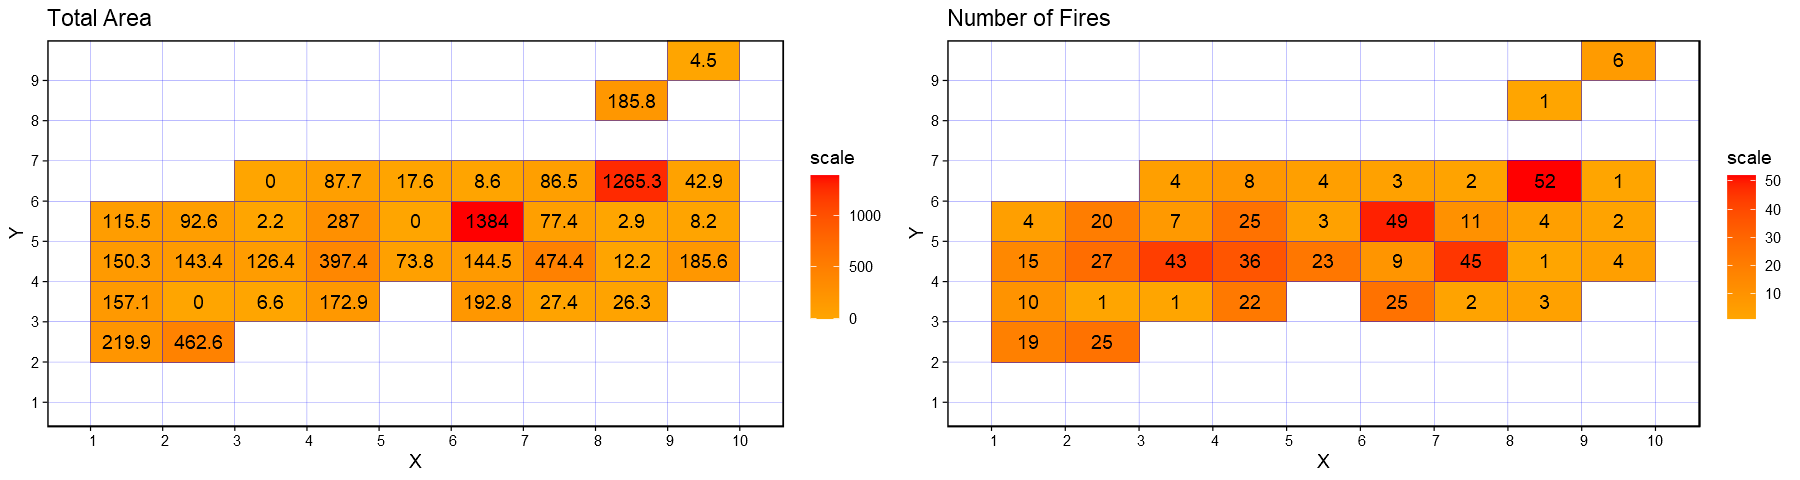

In [15]:
options(repr.plot.width=15, repr.plot.height=4) # managing the size
grid.arrange(area_plot, count_plot, nrow = 1, ncol = 2) # making the plot

A first analysis shows clearly some problematic areas. The interesection between X (6-9) and Y (4-7) accounts for more than half of fires. It will be interesting to how this areas relate to other variables such as tempearture, relative humidity, wind and rain. 	

In [16]:
temp_plot <- areaheatplot(df_spatial$temp, "Temperature")
RH_plot <- areaheatplot(df_spatial$RH, "RH")
wind_plot <- areaheatplot(df_spatial$wind, "Wind")
rain_plot <- areaheatplot(df_spatial$rain, "Rain")

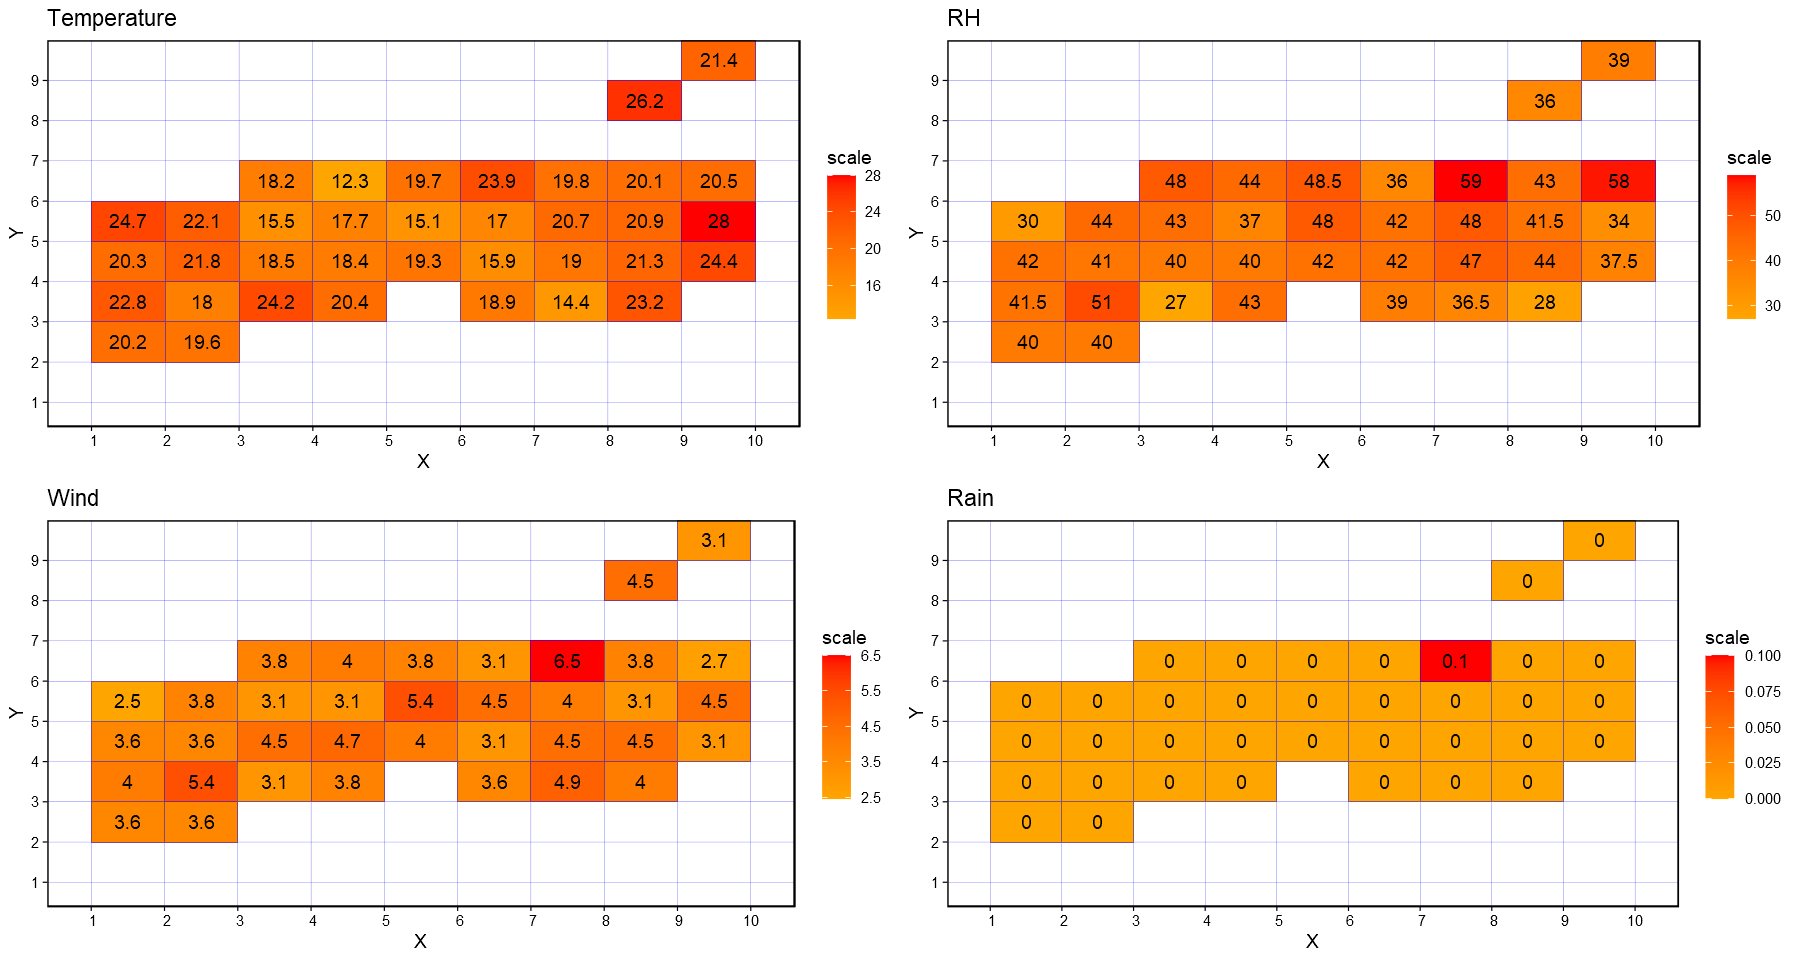

In [17]:
options(repr.plot.width=15, repr.plot.height=8) # managing the size
grid.arrange(temp_plot, RH_plot, wind_plot, rain_plot, nrow = 2, ncol = 2) # making the plot

Unfortunately, we cannot se any clear relationship with the variables that might explain why some areas have more and others less fires. We will later bring the spatial variables to the analysis but now we will proceed to exploring the temporal dimension.

### Temporal Analysis

We will further investigate how seasonality may have an effect on the fires in Portugal. 

In [18]:
df_fires$season <- ifelse(df_fires$month == "dec" | df_fires$month == "jan" | df_fires$month == "feb",'summer', 
                          ifelse(df_fires$month == "mar" | df_fires$month == "apr" | df_fires$month == "may","autumn",
                                 ifelse(df_fires$month == "jun" | df_fires$month == "jul" | df_fires$month =="aug", "winter",
                                        ifelse(df_fires$month == "sep" | df_fires$month == "oct" | df_fires$month =='nov', "spring", 'NA'))))

In [19]:
df_season <- df_fires %>%
  group_by(season, day) %>%
  summarize(Total_Area = sum(logarea, na.rm = TRUE),
            Count_Fires  = n())

In [20]:
season_order <- c("summer", "autumn", "winter", "spring")
p1 <- ggplot(df_fires, aes(x= factor(season, level = season_order), y=logarea)) + geom_boxplot(fill="slateblue", alpha=0.5) + theme_classic() + ggtitle("Distribution Fires by Season")
p2 <- ggplot(df_season, aes(x= factor(season, level = season_order), y=Total_Area)) + geom_bar(fill="grey", stat="identity") + theme_classic() + ggtitle("Distribution Fires by Season")

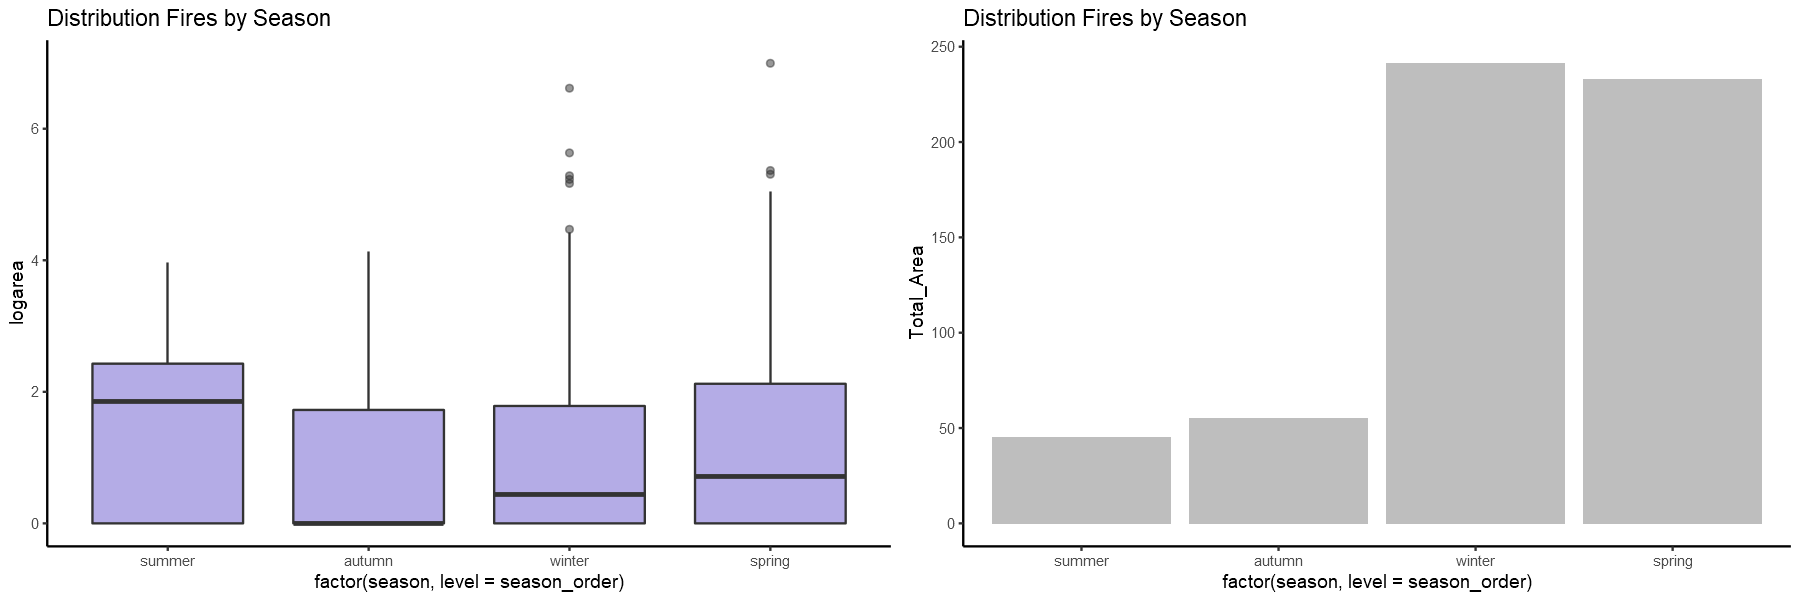

In [21]:
options(repr.plot.width=15, repr.plot.height=5) # managing the size
grid.arrange(p1, p2, nrow = 1, ncol = 2) # making the plot

Apparently due to outliers the area burned during summer was not the highest as expected, but in winter and spring. 

In [22]:
day_order <- c("mon", "tue", "wed", "thu", "fri", "sat", "sun" )

p3 <- ggplot(df_fires, aes(x= factor(day, level = day_order), y =logarea)) + geom_boxplot(fill="slateblue", alpha=0.5) + theme_classic() + ggtitle("Distribution Fires by Season")
p4 <- ggplot(df_season, aes(x= factor(day, level = day_order), y =Total_Area)) + geom_bar(fill="grey", stat="identity") + theme_classic() + ggtitle("Distribution Fires by Season")

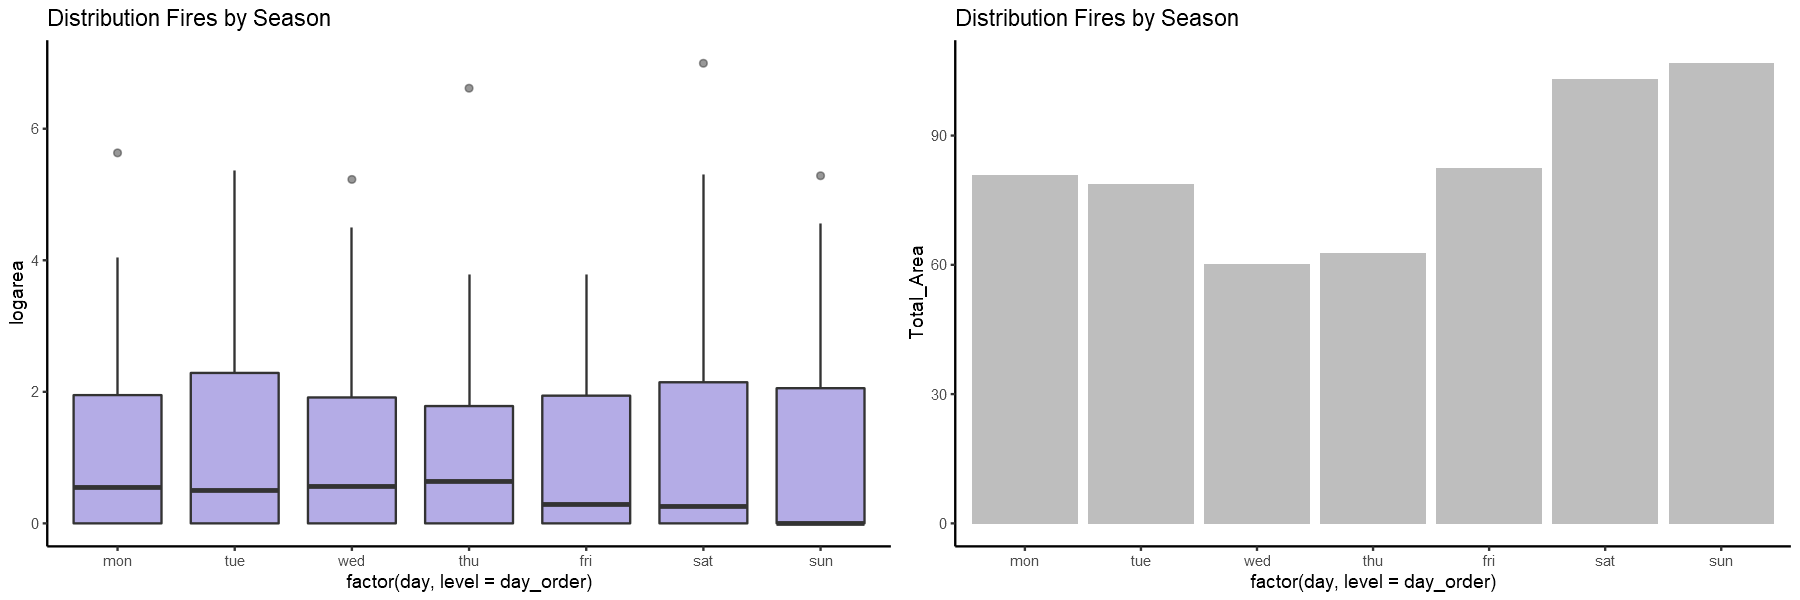

In [23]:
options(repr.plot.width=15, repr.plot.height=5) # managing the size
grid.arrange(p3, p4, nrow = 1, ncol = 2) # making the plot

Important talk about human activity - weekends plus outliers.

## A first look at correlations
Lets investigate how the variables relate to each other. To explore correlations we will leave the previously explored variables - related to temporal and and spatial analysis.

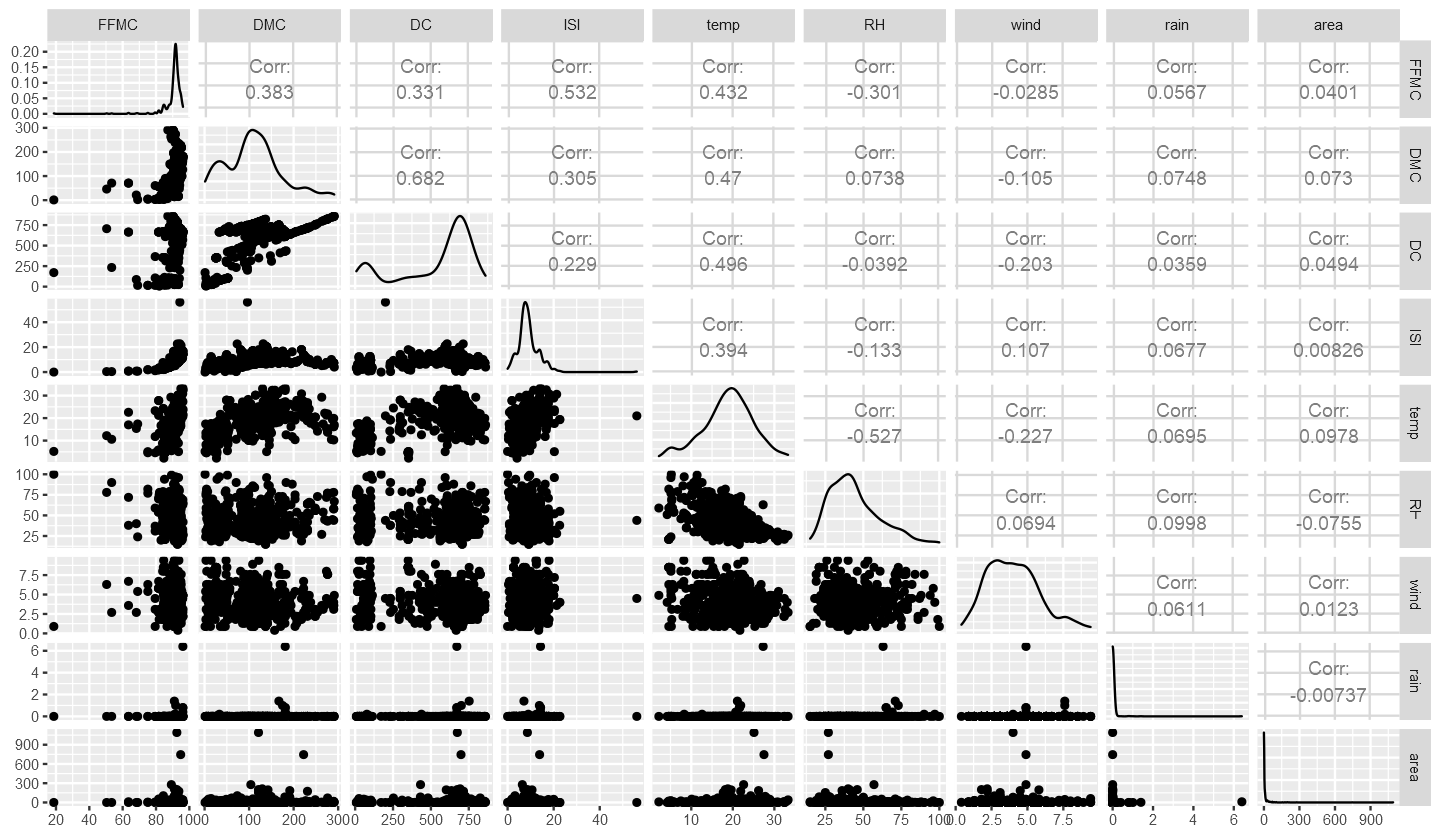

In [46]:
ggpairs(df_fires[,c(seq(5,13))])

This chart is particularly useful as other than the correlation we can see the distribution of the variables. With respect to correlation:
- RH and Temp apparently have a meaningful but small negative correlation.